# **Seq2Seq Model with Attention: Практика**

Привет, друзья! Эта практика полностью посвящена механизму Attention в RNN. Мы будем работать с Seq2Seq моделью, моделью состоящей из двух RNN — ensoder'а и decoder'а. За эту практику вы:

- реализуете простую Seq2Seq модель с 0;
- добавите к модели механизм внимания;
- решите задачу машинного перевода при помощи предобученных моделей;
- проведете анализ карт внимания на предобученных моделях.

Приятного кодинга!

![](https://ucarecdn.com/af53a4f7-2a0c-43b7-b444-dfff60077a33/)

**Обязательно склонируйте репозиторий ниже!**

In [ ]:
!git clone https://github.com/SadSabrina/RNN_with_attention

Cloning into 'RNN_with_attention'...
remote: Enumerating objects: 86, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 86 (delta 8), reused 10 (delta 5), pack-reused 71 (from 1)
Receiving objects: 100% (86/86), 192.70 MiB | 22.69 MiB/s, done.
Resolving deltas: 100% (21/21), done.
Updating files: 100% (24/24), done.


In [ ]:
%cd RNN_with_attention/

/content/RNN_with_attention/RNN_with_attention


In [ ]:
import tqdm
import matplotlib.pyplot as plt
import re
from PIL import Image
from matplotlib import ticker
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

## **Набор данных**

Мы будем работать с данными, собранными трудягами, добровольцами и просто отличными людьми — предложениями на двух языках — русском и английском. Данные взяты с ресурса [tatoeba.org](https://tatoeba.org/), куда люди добавляют постоянно добавляют новые переводы.


Набор данных прост, два столбца:
- `rus` — предложение на русском
- `eng` — предложение на английском

In [ ]:
# Загрузим набор данных
total_df = pd.read_csv('data/rus_eng.csv')
total_df.head()

,rus,eng
0,Давайте что-нибудь попробуем!,Let's try something.
1,Мне пора идти спать.,I have to go to sleep.
2,Что ты делаешь?,What are you doing?
3,Что ты делаешь?,What do you make?
4,Что ты делаешь?,What're you doing?


Уже на данном этапе видно, что в наборе данных есть неявные дубликаты из-за разных способов сказать одно и то же на разных языках. Такие предложения мы оставим в наборе данных. Однако могут быть и другие дубликаты, но в целях оптимизации процесса, мы рассмотрим их наличие после базовой предобработки.

**Вопрос:** сколько дубликатов в сыром датасете?

In [ ]:
# Ваш код здесь

И так сделаем базовую предобработку каждой колонки и посмотрим, появятся ли дубликаты после неё.

In [ ]:
# Функция для предобработки строк датасета

def normalizeString(s):
    s = s.lower().strip() #приводим к нижнему регистру и обрезаем пробелы с краёв
    s = re.sub(r"[^\w\s?]", "", s) # удаляем знаки препинания, кроме вопросительного
    s = re.sub(r"([?])", r" \1", s) # добавляем пробел перед вопросительным знаком
    return s.strip() # снова обрезаем строку с краёв

In [ ]:
total_df['rus'] = total_df['rus'].apply(lambda x: normalizeString(x))
total_df['eng'] = total_df['eng'].apply(lambda x: normalizeString(x))

In [ ]:
print('Дубликатов в наборе данных', total_df.duplicated().sum())

Дубликатов в наборе данных 5528


Поскольку дубликатов появилось больше, удалим разом все.

In [ ]:
total_df.drop_duplicates(inplace=True)

In [ ]:
total_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 724991 entries, 0 to 730518
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   rus     724991 non-null  object
 1   eng     724991 non-null  object
dtypes: object(2)
memory usage: 16.6+ MB


В очищенном наборе данных 724 991 значений. **Сколько из них представляют собой дубликаты на русском языке? (не рассматривая их разный перевод на английский).**

In [ ]:
# Ваш код здесь

Как вы могли заметитьь, все операции с датасетом требуют небольшое, но уже не мнгновенное время. Для ускорения обработки данных, будем работать с только их подмножеством.

In [ ]:
df_sample = total_df.sample(100000, random_state=42) # Не меняйте random_state

## Текст для модели — преобразование данных в "читаемый" сетью вид

Чтобы использовать слова в качестве input'ов и target'ов, нам необходима кодировка. Реализуем её в виде словаря, ставящего в соответствие каждому слову число. Для этого написан класс `Lang` со словарями `word2index` и `index2word`. Кроме того, зарезирвируем два индекса для специальных слов (токенов) `SOS` и `EOS` — start и end of sequence соответственно.

И в дополнение в классе заведем счетчик для каждого слова.

In [ ]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self):
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Счетчик уникальных слов (начиная с 2, так как есть SOS и EOS)

    def addSentences(self, sentences: pd.Series):
        """Добавляет все предложения из pandas Series."""
        sentences.apply(self.addSentence)

    def addSentence(self, sentence):
        """Добавляет отдельное предложение в словарь."""
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        """Добавляет слово в словарь или обновляет счетчик, если слово уже существует."""
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

Чтобы преобразовать данные в релевантный формат перед подачей модели нам нужны:
- список русско-английских пар (где один язык — набор "фичей" и второй — набор "таргетов")
- числовое представделение слов одного и второго языков

Чтобы упростить модели задачу, отфильтруем датасет - уберем все наблюдения длиннее чем 10 токенов. Это даст нам возможность начать получать интересные результаты за 40 минут (Macbook M3 pro, на коллбае будет учиться дольше).


In [ ]:
# Извлечение релевантных столбцов

firtst_lang = df_sample['rus']
target_lang = df_sample['eng']

# Создадим из столбцов пары
pairs = list(zip(firtst_lang, target_lang))

Займемся фильтрацией.
Дополните функцию, реализующую фильтр пар. Она должна "пропускать пару", если оба значения в ней не длиннее (меньше либо равно) MAX_LENGTH и "блокировать пару" иначе.

**Вопрос: сколько пар у вас получилось после реализации? Проверьте корректость выполнения задачи, введя ответ на степик.**

In [ ]:
MAX_LENGTH = 10

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

# Вызовем фильтрацию
pairs = filterPairs(pairs)

print("Отфильтровано до %s  пар (pairs) последовательностей" % len(pairs))
print(random.choice(pairs))

In [ ]:
# Инициализируем классы для хранения языков
input_lang = Lang()
second_lang = Lang()

for pair in pairs:
     input_lang.addSentence(pair[0])
     second_lang.addSentence(pair[1])

print("Посчитанные слова в inputs и outputs:")
print(f'Input sentences содержат {input_lang.n_words} уникальных значений\n Output sentences содержат {second_lang.n_words} уникальных значений')

Посчитанные слова в inputs и outputs:
Input sentences содержат 31868 уникальных значений
 Output sentences содержат 13078 уникальных значений


Обратите внимание, что `input` и `output langs` не содержат те слова, которые встречаются в последовательностях длинее 10 и не встречаются в отфильтрованных. С ними модель не сможет работать.

Теперь закодируем наши последовательности индексами и преобразуем их в тензоры.

In [ ]:
device = 'cpu'

def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')] # предложение в вектор индексов

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(second_lang, pair[1])
    return (input_tensor, target_tensor)

**Рассмотрите код ниже. Чем заполнены остальные значения столбцов, если длина inp_ids < 10?**

In [ ]:
N = len(pairs)
BATCH_SIZE = 200

input_ids = np.zeros((N, MAX_LENGTH), dtype=np.int32) # заготовки для хранения наших входных indexes
target_ids = np.zeros((N, MAX_LENGTH), dtype=np.int32) # заготовки для хранения наших целевых indexes

for idx, (inp, tgt) in enumerate(pairs):
    inp_ids = indexesFromSentence(input_lang, inp)
    inp_ids.append(EOS_token)

    tgt_ids = indexesFromSentence(second_lang, tgt)
    tgt_ids.append(EOS_token)

    input_ids[idx, :len(inp_ids)] = inp_ids #Заполнение тензоров соответствующими значениями
    target_ids[idx, :len(tgt_ids)] = tgt_ids

train_data = TensorDataset(torch.LongTensor(input_ids), torch.LongTensor(target_ids))

train_sampler = RandomSampler(train_data)

train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

## Модель Seq2Seq

Подготовим модель для решения задачи перевода. Она будет составлять из двух частей: кодирующей (encoder) и декодирующей (decoder).

Стадндартная [Sequence to Sequence network](https://arxiv.org/abs/1409.3215) выглядит так:

![](https://pytorch.org/tutorials/_static/img/seq-seq-images/seq2seq.png)

## Encoder-Decoder: base


Encoder сети seq2seq — это RNN, которая в результате преобразований для каждого слова выводит вектор и скрытое состояние и использует скрытое состояние для
следующего входного слова.


![](https://pytorch.org/tutorials/_static/img/seq-seq-images/encoder-network.png)

Decoder сети seq2seq — это другая RNN, которая использует выходные взначения encodera (так называемый context вектор) и последовательно генерирует output.

![](https://pytorch.org/tutorials/_static/img/seq-seq-images/decoder-network.png)


Реализуем простой энкодер. Он будет состоять из:
1. Инициализации эмбеддингов (`nn.Embedding`);
2. Применения dropout;
3. GRU слоя.

Допишите инициализацию эмбеддингов и GRU слой.

In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = # Ваш код здесь — слой, генерирующий эмбеддинги'
        self.dropout = nn.Dropout(dropout_p)
        self.gru = # Ваш код здесь — GRU слой


    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

**Реализуйте тестовый экнодер. Чему равна сумма размерностей скрытых состояний?**


In [ ]:
test_encoder = EncoderRNN(2, 3)

test_tensor = torch.LongTensor(2)

test_encoder(test_tensor)[1].shape

## Мотивация Attention

Идея внимания проста — оно позволяет модели связывать различные части входной и выходной последовательности. Представить актуальность этого в задаче машинного перевода легко:
- Русский: "Завтра я пойду в кино."
- Английский: "I will go to the movies tomorrow."


## Attention — Bahdanau & Luong

Подходов к вычислению внимания существует много, например Bahdanau-Attention, Luong-Attention, Self-attention и другие. Также, само внимание можно по разному улучшать и наделять информацией, через:
- Обычное скалярное произведение: $e_i = \{(s_i, h_0), ..., (s_i, h_n)\} = [s_i h_j^T]_{j=0}^n$ — dot attention, aka Luong Attention
- Мультипликативное внимание с матрицей весов $W$: $e_i = [s_iWh_j^T]_{j=0}^n$, где $W$ - обучаемая матрица весов (это получается обобщение скалярного произведения) - general attention, aka Luong Attention
- Bahdanau attention (MLP): $e_{ij} = tanh(h_jW_1 + s_iW_2)v$, где $W_1, W_2$ - обучаемые матрицы весов, а $v$ - обучаемый вектор весов.

Кроме того, во всех примерах выше:
$(h_0, h_1, ..., h_n)$ - векторы скрытого состояния кодировщика
$(s_0 = h_n, s_1, ..., s_m)$ - векторы скрытого состояния декодировщика

Мы в этом туториале будем реализовывать Bahdanau attention и первые две модификации, называемые Luong Attention. Вообще, понятием Luong Attention обобщаются способы:

- dot attention: $s_i^Th_j$ — скалярно перемножаем скрытые слои энкодера и декодера
- general attention: $s_i^TW_1h_j$ —  перемножаем скрытые слои энкодера и декодера с промежуточной матрицей весов между ними
- concat attention: $v^Ttanh(W_1[s_i;h_j])$ — умножаем обучаемый вектор весов на тангенс от взвешенного векторного произведения скрытых слоёв энкодера и декодера


Реализации обоих механизмов вы можете подсмотреть в файле `attentions.py`. Здесь рассмотрим реализацию Decoder'а с механизмом внимания и применением [teacher forcing](https://en.wikipedia.org/wiki/Teacher_forcing#:~:text=Teacher%20forcing%20is%20an%20algorithm,to%20the%20ground%2Dtruth%20sequence.).


In [ ]:
from attentions import BahdanauAttention, LuongAttention

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, method=None):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)

        if method:
            print(f'Luong Attention with {method} is used')
            self.attention = LuongAttention(method, hidden_size)

        else:
            print(f'Bahdanau Attention is used')
            self.attention = BahdanauAttention(hidden_size)

        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):         # получаем вектора скрытых и выходных состояний энкодера
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)    # задаем пустой вход декодера, заполняя его SOS токенами
        decoder_hidden = encoder_hidden                                             # размерность скрытого слоя декодера приравниваем к разм-ти энкодера
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: подаем таркет как следующий вход
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: стандартный подход к обучению
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):

        embedded =  self.dropout(self.embedding(input))

        decoder_hidden = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(decoder_hidden, encoder_outputs) # Обратите внимание, какие сущности связывает attention
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

**Какие сущности выдаваемые и принимаемые моделями связывает attention? Выберите ответ на степик.**

# Тренировка и оценка модели.
Для этого уже написаны функции `train_epoch` и `train`. Вы можете просто импортировать их из файла `helper.py`.

In [ ]:
from helper import train_epoch, train

hidden_size = 128

# Инициализируем одну из моделей LUONG DOT
# BAHDANAU
bahdanau_encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
bahdanau_decoder = AttnDecoderRNN(hidden_size, second_lang.n_words).to(device)

Bahdanau Attention is used


Теперь, чтобы запустить обучение вам достаточно запустить ячейку ниже. Однако, с целью экономии времени, для получения карт воспольщуемся предобученными моделями.

In [ ]:
#bahdanau_losses, bahdanau_time = train(train_dataloader, bahdanau_encoder, bahdanau_decoder, 50, print_every=5)

In [ ]:
hidden_size = 128
device = 'cpu'

# LUONG DOT
dot_encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
dot_decoder = AttnDecoderRNN(hidden_size, second_lang.n_words, method='dot').to(device)

# LUONG GENERAL
general_encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
general_decoder = AttnDecoderRNN(hidden_size, second_lang.n_words, method='general').to(device)

# LUONG CONCAT
concat_encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
concat_decoder = AttnDecoderRNN(hidden_size, second_lang.n_words, method='concat').to(device)

# BAHDANAU
bahdanau_encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
bahdanau_decoder = AttnDecoderRNN(hidden_size, second_lang.n_words).to(device)

Luong Attention with dot is used
Luong Attention with general is used
Luong Attention with concat is used
Bahdanau Attention is used


In [ ]:
# DOT ATTENTION
dot_encoder.load_state_dict(torch.load('models/dot_encoder', weights_only=True))
dot_encoder.eval()

dot_decoder.load_state_dict(torch.load('models/dot_decoder', weights_only=True))
dot_decoder.eval()

AttnDecoderRNN(
  (embedding): Embedding(13078, 128)
  (attention): LuongAttention()
  (gru): GRU(256, 128, batch_first=True)
  (out): Linear(in_features=128, out_features=13078, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [ ]:
# GENERAL
general_encoder.load_state_dict(torch.load('models/general_encoder', weights_only=True))
general_encoder.eval()

general_decoder.load_state_dict(torch.load('models/general_decoder', weights_only=True))
general_decoder.eval()

AttnDecoderRNN(
  (embedding): Embedding(13078, 128)
  (attention): LuongAttention(
    (Wa): Linear(in_features=128, out_features=128, bias=True)
  )
  (gru): GRU(256, 128, batch_first=True)
  (out): Linear(in_features=128, out_features=13078, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [ ]:
# CONCAT
concat_encoder.load_state_dict(torch.load('models/concat_encoder', weights_only=True))
concat_encoder.eval()

concat_decoder.load_state_dict(torch.load('models/concat_decoder', weights_only=True))
concat_decoder.eval()

AttnDecoderRNN(
  (embedding): Embedding(13078, 128)
  (attention): LuongAttention(
    (Wa): Linear(in_features=256, out_features=128, bias=True)
  )
  (gru): GRU(256, 128, batch_first=True)
  (out): Linear(in_features=128, out_features=13078, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [ ]:
# BAHDANAU
bahdanau_encoder.load_state_dict(torch.load('models/bahdanau_encoder', weights_only=True))
bahdanau_encoder.eval()

bahdanau_decoder.load_state_dict(torch.load('models/bahdanau_decoder', weights_only=True))
bahdanau_decoder.eval()

AttnDecoderRNN(
  (embedding): Embedding(13078, 128)
  (attention): BahdanauAttention(
    (Wa): Linear(in_features=128, out_features=128, bias=True)
    (Ua): Linear(in_features=128, out_features=128, bias=True)
    (Va): Linear(in_features=128, out_features=1, bias=True)
  )
  (gru): GRU(256, 128, batch_first=True)
  (out): Linear(in_features=128, out_features=13078, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

## Визуализация вниманий.
Рассмотрим предложение "я люблю кошек". И оценим, как с ними справятся модели, обученные в одинаковых условиях, но с разными механизмами внимания.


In [ ]:
encoders_decoders_pairs = [(dot_encoder, dot_decoder), (concat_encoder, concat_decoder), (general_encoder, general_decoder), (bahdanau_encoder, bahdanau_decoder)]
keys = ['DOT', 'CONCAT', 'GENERAL', 'BAHDANAU']

In [ ]:
# Функция для получения прогноза модели (1)

def evaluate(encoder, decoder, sentence, input_lang, output_lang): # Получаем энкодер, декодер, предложение, а также input и output словари (Lang)
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence) # преобразуем предложение в тензор, используя слова в input_lang

        encoder_outputs, encoder_hidden = encoder(input_tensor) # подаем предложение в энкодер
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden) # подаем предложение в декодер

        _, topi = decoder_outputs.topk(1) # получаем прогноз
        decoded_ids = topi.squeeze()

        decoded_words = []    # Производим декодировку слов
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('EOS')
                break
            decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words, decoder_attn

input = я люблю кошек
output = i like cats but cats dont smoke EOS


<ipython-input-60-1855bf7f9183>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') +
<ipython-input-60-1855bf7f9183>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


input = я люблю кошек
output = i love cats insects EOS
input = я люблю кошек
output = i like cats but i love cats EOS
input = я люблю кошек
output = i love cats cats EOS


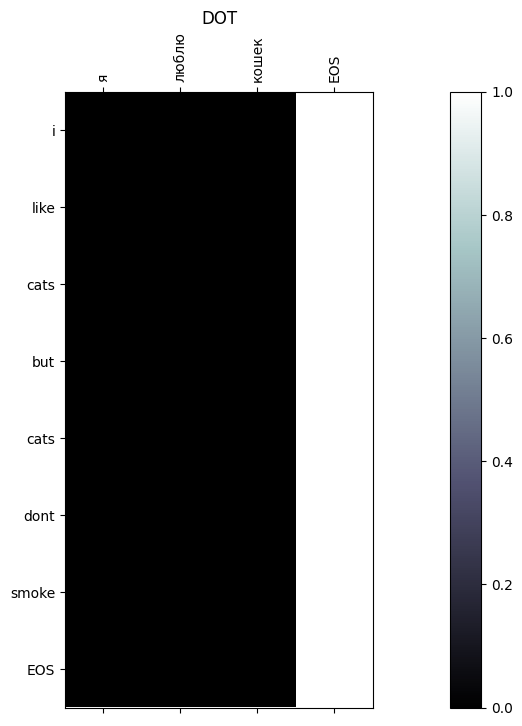

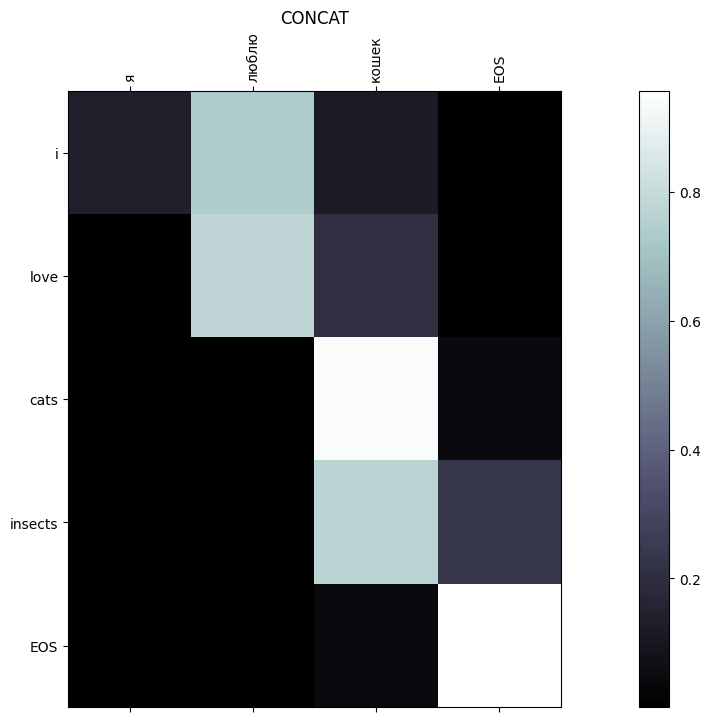

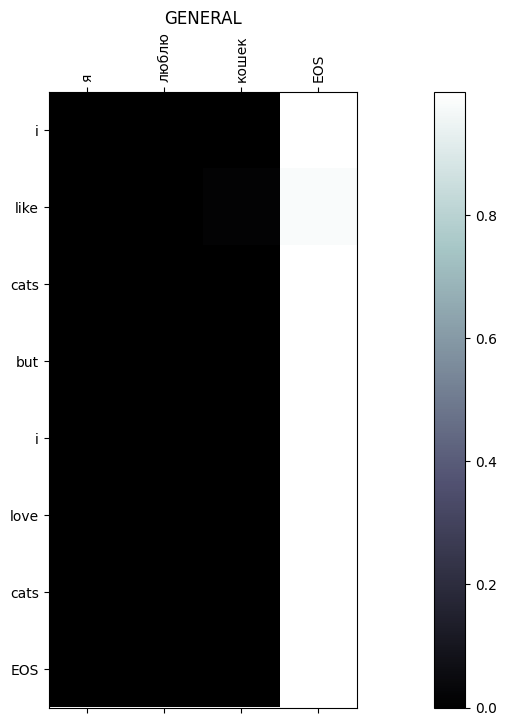

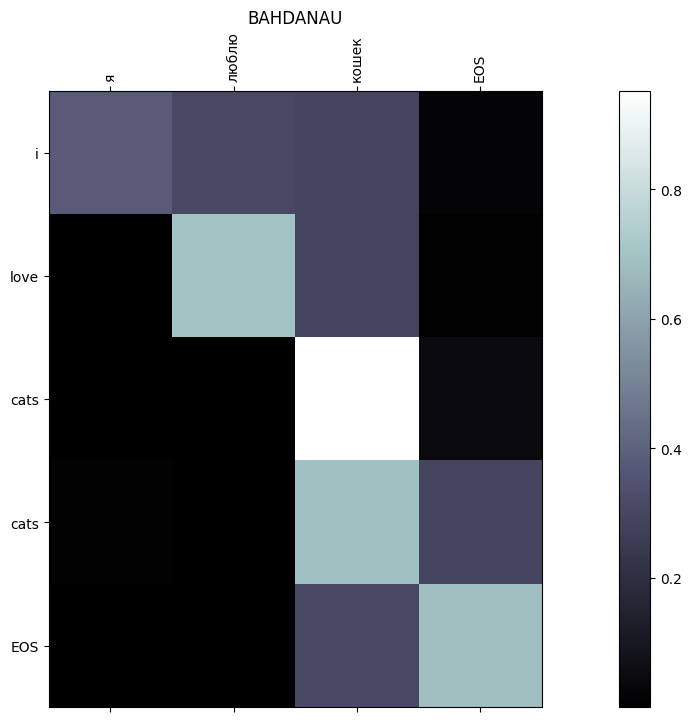

In [ ]:
# Функция для визуализауии вниманий (2)

def showAttention(input_sentence, output_words, attentions): # получаем предложение, слова и внимания

    fig = plt.figure(figsize=(20, 8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.cpu().numpy(), cmap='bone') # изображаем веса в виде матрицы
    fig.colorbar(cax)

    # Настраиваем названия на ячейках
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['EOS'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# Соединяем функции 1 и 2, а также сохраняем результат

def evaluateAndShowAttention(input_sentence, title, encoder, decoder): # получаем предложение, газвание графика, энкодер и декодер

    output_words, attentions = evaluate(encoder, decoder, input_sentence, input_lang, second_lang) # Получаем слова и внимания
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions[0, :len(output_words), :]) # визуализируем полученную матрицу
    plt.title(title)

    plt.savefig(f'{title}.png') # сохраняем график



for enc_dec, key in zip(encoders_decoders_pairs, keys):
    enc, dec = enc_dec
    evaluateAndShowAttention('я люблю кошек', key, enc, dec)

In [ ]:
# Загрузим численные результаты обучения
train_results_data = pd.read_csv('results_data.csv',
                                 index_col=0)

train_results_data

,mean loss,median loss,training time minutes
without,1.056864,0.827356,32.760236
dot,1.061731,0.835960,36.256661
general,1.032140,0.806987,37.387139
concat,0.856844,0.599806,40.020917
bahdanau,0.374914,0.339739,39.651543


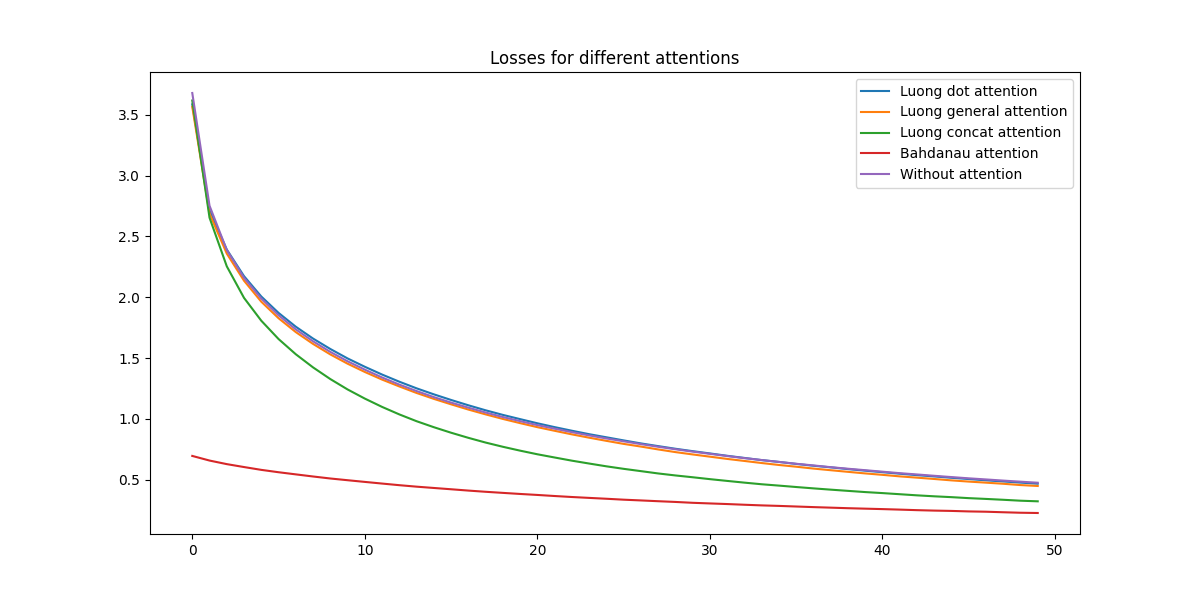

In [ ]:
img = Image.open('results/Losses.png')

img

**Сравните полученные карты внимания и проанализируйте полученные карты внимания, а также данные об обучении моделей. Зафиксируйте выводы и отправвьте их в форме свободного эссе на степик.**